In [1]:
import pandas as pd
import numpy as np
import pickle
import seaborn as sns
from pathlib import Path

import matplotlib.pyplot as plt
import itertools

from keras.preprocessing.text import Tokenizer
from keras.models import Sequential, Model
from keras.layers import Activation, Dense, Dropout
from keras.utils import to_categorical

from sklearn.preprocessing import LabelBinarizer
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import confusion_matrix
from sklearn.metrics import f1_score
from sklearn.metrics import accuracy_score

from imblearn.over_sampling import RandomOverSampler
from imblearn.over_sampling import ADASYN
from imblearn.over_sampling import SMOTE

# For reproducibility
np.random.seed(56)

Using TensorFlow backend.


In [2]:
df = pd.read_csv("Modelar_UH2020.txt", sep = "|")
df.head()

,ID,X,Y,Q_R_4_0_0,Q_R_4_0_1,Q_R_4_0_2,Q_R_4_0_3,Q_R_4_0_4,Q_R_4_0_5,Q_R_4_0_6,...,Q_NIR_8_1_0,AREA,GEOM_R1,GEOM_R2,GEOM_R3,GEOM_R4,CONTRUCTIONYEAR,MAXBUILDINGFLOOR,CADASTRALQUALITYID,CLASE
0,35984B9C3E7CD9A1,2207357872,165920300,0.000000,443.001300,616.001697,746.998401,872.996472,1009.000946,1159.002319,...,10951.926645,144.426900,0.557237,0.067249,0.057372,0.853127,2002,0.0,2,RESIDENTIAL
1,F9D04BF6D037F8FB,2189757160,165463267,0.000059,443.899011,627.999060,770.001611,904.999988,1032.998474,1165.001636,...,7048.367637,38.342550,0.709884,0.125156,0.147929,1.181953,1949,1.0,8,RESIDENTIAL
2,B89D5711AFF8C423,2240147335,165690752,0.000000,353.502274,523.003601,644.001831,760.997131,876.999634,1006.997498,...,7013.073271,108.794384,0.517702,0.058268,0.081666,1.401552,1986,1.0,5,RESIDENTIAL
3,1C3478AC1522E7E4,2227146459,165934099,0.000000,268.000613,376.999609,478.003784,575.001233,683.997742,809.005994,...,6216.880538,155.224455,0.450871,0.053591,0.054201,1.011382,1999,1.0,2,RESIDENTIAL
4,4D12AA5009064345,2212350459,165681791,0.000000,318.997910,492.003845,632.999634,757.002197,882.999908,1019.008911,...,7092.767616,1789.873366,0.458819,0.012858,0.019936,1.550478,1966,8.0,6,RESIDENTIAL


In [3]:
df.CLASE = pd.Categorical(df.CLASE)
df.CLASE = df.CLASE.cat.codes

y = to_categorical(df.CLASE)

In [4]:
#df.info()

### Primera cosa rara... las dimensiones MAXBUILDINGFLOOR y CADASTRALQUALITYID tienen menos registros
Me cargo los registros nulos.

In [5]:
df.dropna(inplace = True)

In [6]:
df.isnull().sum().max()

0

Al carrer

In [7]:
df = df[df["CADASTRALQUALITYID"]!="A"]
df = df[df["CADASTRALQUALITYID"]!="B"]
df = df[df["CADASTRALQUALITYID"]!="C"]

### Me cargo las categóricas


In [8]:
df.drop(df[["ID", "CADASTRALQUALITYID"]], axis = "columns", inplace = True)

In [9]:
df.head()

,X,Y,Q_R_4_0_0,Q_R_4_0_1,Q_R_4_0_2,Q_R_4_0_3,Q_R_4_0_4,Q_R_4_0_5,Q_R_4_0_6,Q_R_4_0_7,...,Q_NIR_8_0_9,Q_NIR_8_1_0,AREA,GEOM_R1,GEOM_R2,GEOM_R3,GEOM_R4,CONTRUCTIONYEAR,MAXBUILDINGFLOOR,CLASE
0,2207357872,165920300,0.000000,443.001300,616.001697,746.998401,872.996472,1009.000946,1159.002319,1342.002466,...,3180.000342,10951.926645,144.426900,0.557237,0.067249,0.057372,0.853127,2002,0.0,5
1,2189757160,165463267,0.000059,443.899011,627.999060,770.001611,904.999988,1032.998474,1165.001636,1316.000110,...,3012.991675,7048.367637,38.342550,0.709884,0.125156,0.147929,1.181953,1949,1.0,5
2,2240147335,165690752,0.000000,353.502274,523.003601,644.001831,760.997131,876.999634,1006.997498,1168.995544,...,3088.000488,7013.073271,108.794384,0.517702,0.058268,0.081666,1.401552,1986,1.0,5
3,2227146459,165934099,0.000000,268.000613,376.999609,478.003784,575.001233,683.997742,809.005994,955.002960,...,3349.986328,6216.880538,155.224455,0.450871,0.053591,0.054201,1.011382,1999,1.0,5
4,2212350459,165681791,0.000000,318.997910,492.003845,632.999634,757.002197,882.999908,1019.008911,1175.993103,...,2315.991455,7092.767616,1789.873366,0.458819,0.012858,0.019936,1.550478,1966,8.0,5


In [10]:
clases = df["CLASE"].unique().tolist()
print(clases)

[5, 1, 4, 2, 3, 6, 0]


### Comprobamos lo "no balanceado" que está el dataset.

In [11]:
df["CLASE"].value_counts()

5    90048
1     4452
4     2915
6     2072
2     1784
3     1330
0      313
Name: CLASE, dtype: int64

In [12]:
print('AGRICULTURE', round(df['CLASE'].value_counts()[0]/len(df) * 100,2), '% of the dataset')
print('INDUSTRIAL', round(df['CLASE'].value_counts()[1]/len(df) * 100,2), '% of the dataset')
print('OFFICE', round(df['CLASE'].value_counts()[2]/len(df) * 100,2), '% of the dataset')
print('OTHER', round(df['CLASE'].value_counts()[3]/len(df) * 100,2), '% of the dataset')
print('PUBLIC', round(df['CLASE'].value_counts()[4]/len(df) * 100,2), '% of the dataset')
print('RESIDENTIAL', round(df['CLASE'].value_counts()[5]/len(df) * 100,2), '% of the dataset')
print('RETAIL', round(df['CLASE'].value_counts()[6]/len(df) * 100,2), '% of the dataset')

AGRICULTURE 0.3 % of the dataset
INDUSTRIAL 4.33 % of the dataset
OFFICE 1.73 % of the dataset
OTHER 1.29 % of the dataset
PUBLIC 2.83 % of the dataset
RESIDENTIAL 87.5 % of the dataset
RETAIL 2.01 % of the dataset


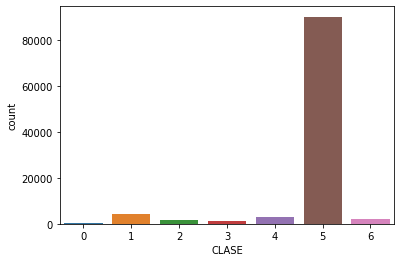

In [13]:
sns.countplot('CLASE', data=df)

### Siguiente paso: limpieza de outliers

In [14]:
cl_df = df.copy()

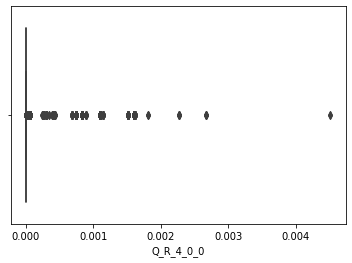

In [15]:
sns.boxplot(x=cl_df['Q_R_4_0_0'])

Voy a limpiar los outliers filtrando por CLASE. Al ppio he limpiado outliers sin distinguir por clase, y me reventaba la proporción. La clase 0 y 1 desaparecían, eran todo outliers...

In [16]:
#Proceso de outliers para todo:
#z = np.abs(stats.zscore(cl_df))
#cl_df_o = cl_df[(z < threshold).all(axis=1)]


In [17]:
np.seterr(divide='ignore', invalid='ignore')

{'divide': 'warn', 'over': 'warn', 'under': 'ignore', 'invalid': 'warn'}

In [18]:
df_0 = cl_df[cl_df["CLASE"]==0]
df_0.head()

,X,Y,Q_R_4_0_0,Q_R_4_0_1,Q_R_4_0_2,Q_R_4_0_3,Q_R_4_0_4,Q_R_4_0_5,Q_R_4_0_6,Q_R_4_0_7,...,Q_NIR_8_0_9,Q_NIR_8_1_0,AREA,GEOM_R1,GEOM_R2,GEOM_R3,GEOM_R4,CONTRUCTIONYEAR,MAXBUILDINGFLOOR,CLASE
322,2197577861,165936157,0.000000e+00,547.999719,658.000720,744.002570,825.000037,905.998535,993.999573,1105.999500,...,2927.997778,6119.452051,49.77635,0.418703,0.096061,0.087566,0.911559,1972,1.0,0
917,2217736847,165974592,0.000000e+00,262.999878,419.999402,576.000446,714.997888,853.998657,1014.995728,1211.997327,...,2893.996802,8283.026618,283.92985,0.020315,0.006143,0.011648,1.896331,1970,1.0,0
975,2276414867,165894095,0.000000e+00,463.004102,659.002795,781.003503,896.000037,1017.000336,1158.995068,1335.999243,...,3256.998389,7368.409099,694.82996,0.107754,0.012219,0.012692,1.038730,2012,2.0,0
1000,2134138279,165924322,2.267414e-03,533.001392,613.999878,670.999329,729.998694,804.000824,898.999402,1021.001392,...,2831.996167,4889.337995,58.05681,0.667435,0.136231,0.084388,0.619451,1990,4.0,0
1516,2262635252,165306155,4.509644e-07,562.000458,720.999756,822.001953,913.001221,1024.999084,1164.000244,1337.000366,...,2650.998291,6604.024144,879.82035,0.424188,0.029762,0.016200,0.544306,1991,1.0,0


In [186]:
z0 = np.abs(stats.zscore(df_0))
print(z0)

[[0.41876561 0.30685375 0.45955359 ... 0.47528198 0.47386826        nan]
 [0.09160602 0.41607217 0.45955359 ... 0.59935476 0.47386826        nan]
 [1.57717663 0.1873287  0.45955359 ... 2.00617357 0.13368302        nan]
 ...
 [0.97220121 1.44121357 0.0845417  ... 0.51730024 0.47386826        nan]
 [0.35266103 0.79525488 0.4051794  ... 0.9095367  0.47386826        nan]
 [0.35837217 1.86028011 0.45955359 ... 2.19228274 1.22705794        nan]]


In [206]:
df_0[(z0 < threshold).all(axis=1)]

,X,Y,Q_R_4_0_0,Q_R_4_0_1,Q_R_4_0_2,Q_R_4_0_3,Q_R_4_0_4,Q_R_4_0_5,Q_R_4_0_6,Q_R_4_0_7,...,Q_NIR_8_0_9,Q_NIR_8_1_0,AREA,GEOM_R1,GEOM_R2,GEOM_R3,GEOM_R4,CONTRUCTIONYEAR,MAXBUILDINGFLOOR,CLASE


In [203]:
df_0 = cl_df[cl_df["CLASE"]==0]
df_1 = cl_df[cl_df["CLASE"]==1]
df_2 = cl_df[cl_df["CLASE"]==2]
df_3 = cl_df[cl_df["CLASE"]==3]
df_4 = cl_df[cl_df["CLASE"]==4]
df_5 = cl_df[cl_df["CLASE"]==5]
df_6 = cl_df[cl_df["CLASE"]==6]

In [148]:
from scipy import stats

z0 = np.abs(stats.zscore(df_0))
z1 = np.abs(stats.zscore(df_1))
z2 = np.abs(stats.zscore(df_2))
z3 = np.abs(stats.zscore(df_3))
z4 = np.abs(stats.zscore(df_4))
z5 = np.abs(stats.zscore(df_5))
z6 = np.abs(stats.zscore(df_6))

threshold = 3

In [157]:
df_0 = df_0[(z0 < threshold).all(axis=1)]

#df_1 = df_1[(z1 < 3).all(axis=1)]
#df_2 = df_2[(z2 < 3).all(axis=1)]
#df_3 = df_3[(z3 < 3).all(axis=1)]
#df_4 = df_4[(z4 < 3).all(axis=1)]
#df_5 = df_5[(z5 < 3).all(axis=1)]
#df_6 = df_6[(z6 < 3).all(axis=1)]

In [83]:
df_0.shape

(0, 54)

In [158]:
cl_df_o = cl_df[(z < 3).all(axis=1)]

In [27]:
cl_df_o.shape

(77456, 54)

In [28]:
cl_df.shape

(102914, 54)

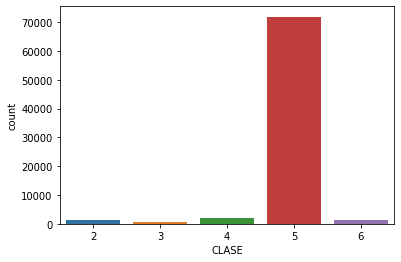

In [63]:
sns.countplot('CLASE', data=cl_df_o)

In [65]:
cl_df_o["CLASE"].value_counts()


5    71864
4     2036
6     1486
2     1272
3      798
Name: CLASE, dtype: int64

In [60]:
print('AGRICULTURE', round(cl_df['CLASE'].value_counts()[0]/len(cl_df) * 100,2), '% of the dataset without outliers')
print('AGRICULTURE', round(df['CLASE'].value_counts()[0]/len(df) * 100,2), '% of the dataset')

print('INDUSTRIAL', round(df['CLASE'].value_counts()[1]/len(df) * 100,2), '% of the dataset')
print('INDUSTRIAL', round(df['CLASE'].value_counts()[1]/len(df) * 100,2), '% of the dataset')

print('OFFICE', round(df['CLASE'].value_counts()[2]/len(df) * 100,2), '% of the dataset')

print('OTHER', round(df['CLASE'].value_counts()[3]/len(df) * 100,2), '% of the dataset')

print('PUBLIC', round(df['CLASE'].value_counts()[4]/len(df) * 100,2), '% of the dataset')

print('RESIDENTIAL', round(df['CLASE'].value_counts()[5]/len(df) * 100,2), '% of the dataset')

print('RETAIL', round(df['CLASE'].value_counts()[6]/len(df) * 100,2), '% of the dataset')


AGRICULTURE 0.3 % of the dataset without outliers
AGRICULTURE 0.3 % of the dataset
INDUSTRIAL 4.33 % of the dataset
INDUSTRIAL 4.33 % of the dataset
OFFICE 1.73 % of the dataset
OTHER 1.29 % of the dataset
PUBLIC 2.83 % of the dataset
RESIDENTIAL 87.5 % of the dataset
RETAIL 2.01 % of the dataset


### Separo dataset, e igualo distribuciones


In [20]:
# Use a utility from sklearn to split and shuffle our dataset.
train_df, test_df = train_test_split(cl_df_o, test_size=0.2)
train_df, val_df = train_test_split(train_df, test_size=0.3)

# Form np arrays of labels and features.
train_labels = np.array(train_df.pop('CLASE'))
bool_train_labels = train_labels != 0
val_labels = np.array(val_df.pop('CLASE'))
test_labels = np.array(test_df.pop('CLASE'))

train_features = np.array(train_df)
val_features = np.array(val_df)
test_features = np.array(test_df)

Normalize the input features using the sklearn StandardScaler. This will set the mean to 0 and standard deviation to 1.

In [21]:
scaler = StandardScaler()
train_features = scaler.fit_transform(train_features)

val_features = scaler.transform(val_features)
test_features = scaler.transform(test_features)

train_features = np.clip(train_features, -5, 5)
val_features = np.clip(val_features, -5, 5)
test_features = np.clip(test_features, -5, 5)


print('Training labels shape:', train_labels.shape)
print('Validation labels shape:', val_labels.shape)
print('Test labels shape:', test_labels.shape)

print('Training features shape:', train_features.shape)
print('Validation features shape:', val_features.shape)
print('Test features shape:', test_features.shape)

Training labels shape: (57631,)
Validation labels shape: (24700,)
Test labels shape: (20583,)
Training features shape: (57631, 53)
Validation features shape: (24700, 53)
Test features shape: (20583, 53)


# KNN sin hacer resampling

In [31]:
classifier = KNeighborsClassifier(n_neighbors = 9, p = 2, metric = "euclidean")

In [32]:
classifier.fit(train_features, train_labels)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='euclidean',
                     metric_params=None, n_jobs=None, n_neighbors=9, p=2,
                     weights='uniform')

In [33]:
label_pred = classifier.predict(test_features)

In [34]:
cm = confusion_matrix(test_labels, label_pred)
print(cm)

[[   26     1     5   210     1]
 [    1    23     7   126     0]
 [   17     7    29   385     1]
 [   18     8    30 14309     5]
 [    1     1    12   236    33]]


In [35]:
print(accuracy_score(test_labels, label_pred))

0.9308029950942421


## Oversampling ADASYN

In [36]:
Xtr_resampled, ytr_resampled = ADASYN().fit_resample(train_features, train_labels)
Xval_resampled, yval_resampled = ADASYN().fit_resample(val_features, val_labels)
Xtst_resampled, ytst_resampled = ADASYN().fit_resample(test_features, test_labels)

In [37]:
classifier = KNeighborsClassifier(n_neighbors = 9, p = 2, metric = "euclidean")
classifier.fit(Xtr_resampled, ytr_resampled)
label_pred_resampled = classifier.predict(Xtst_resampled)


In [38]:
cm_res = confusion_matrix(ytst_resampled, label_pred_resampled)
print(cm_res)

[[ 5945   642  2826  2900  2087]
 [ 1237  6055  3274  2471  1384]
 [ 2192  1699  5458  2656  2417]
 [  994   382  1249 10546  1199]
 [ 2063   775  2282  4452  4830]]


In [39]:
print(accuracy_score(ytst_resampled, label_pred_resampled))

0.45593279177949037


#### Basura

### Segundo intento de resampling - SMOTE

In [40]:
Xtr_resampled1, ytr_resampled1 = SMOTE().fit_resample(train_features, train_labels)
Xval_resampled1, yval_resampled1 = SMOTE().fit_resample(val_features, val_labels)
Xtst_resampled1, ytst_resampled1 = SMOTE().fit_resample(test_features, test_labels)

classifier = KNeighborsClassifier(n_neighbors = 9, p = 2, metric = "euclidean")
classifier.fit(Xtr_resampled1, ytr_resampled1)
label_pred_resampled1 = classifier.predict(Xtst_resampled1)

In [41]:
cm_res1 = confusion_matrix(ytst_resampled1, label_pred_resampled1)
print(cm_res1)

[[ 6213   590  2700  2684  2183]
 [ 1238  6094  3325  2311  1402]
 [ 2156  1733  5650  2483  2348]
 [  965   372  1190 10691  1152]
 [ 1878   627  2125  4183  5557]]


In [42]:
print(accuracy_score(ytst_resampled1, label_pred_resampled1))

0.47606123869171885


#### Más basura

### A la tercera va la vencida

In [48]:
over_sampler = RandomOverSampler()
x_train_over, y_train_over = over_sampler.fit_sample(train_features, train_labels)

classifier = KNeighborsClassifier(n_neighbors = 9, p = 10, metric = "euclidean")
classifier.fit(x_train_over, y_train_over)
label_pred_resampled2 = classifier.predict(x_train_over)

In [49]:
cm_res2 = confusion_matrix(y_train_over, label_pred_resampled2)
print(cm_res2)

[[50426     0     0     0     0     0     0]
 [    0 50426     0     0     0     0     0]
 [    0     0 50426     0     0     0     0]
 [    0     0     0 50426     0     0     0]
 [    0     0     0     0 50426     0     0]
 [   43  1544  1326   532  2076 43214  1691]
 [    0     0     0     0     0     0 50426]]


In [50]:
print(accuracy_score(y_train_over, label_pred_resampled2))

0.9795683632593163


# SIUUUUUU

### Esto está bien??

## 97,94% ?????

In [51]:
#Lo paso por Validation

In [52]:
label_pred_val1 = classifier.predict(val_features)

In [53]:
print(accuracy_score(val_labels, label_pred_val1))

0.7798785425101215


In [54]:
cm_res4 = confusion_matrix(val_labels, label_pred_val1)
print(cm_res4)

[[   46     8     2     1     2     8     2]
 [   14   635    81    21    66   176    72]
 [    1    91   116    10    38   117    41]
 [    0    40    18   128    41    59    13]
 [    4    64    71    55   245   258    62]
 [   27   740   677   257  1084 17959   884]
 [    1    66    40    14    41   170   134]]


### Not bad... but not good enough

In [55]:
label_pred_test = classifier.predict(test_features)

In [56]:
print(accuracy_score(test_labels, label_pred_test))

0.7831219938784434


In [57]:
cm_test = confusion_matrix(test_labels, label_pred_test)
print(cm_test)

[[   37    16     1     0     3    10     2]
 [    7   557    72    20    49   128    44]
 [    1    70    93     7    45   115    48]
 [    3    35    14   116    38    61    14]
 [    6    47    47    45   173   179    57]
 [   10   590   605   210   857 15012   710]
 [    2    44    31    17    35   169   131]]


### Hypertunning model parameters
Busco para que n se entrena mejor mi modelo

In [47]:
from sklearn.model_selection import GridSearchCV

In [ ]:
knn2 = KNeighborsClassifier()
#create a dictionary of all values we want to test for n_neighbors
param_grid = {"n_neighbors": np.arange(1, 25)}
#use gridsearch to test all values for n_neighbors
knn_gscv = GridSearchCV(knn2, param_grid, cv=5)
#fit model to data
knn_gscv.fit(x_train_over, y_train_over)

In [ ]:
knn_gscv.best_score_